# A/B-тестирование

## Введение

Задача проекта — провести оценку результатов A/B-теста. В распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## Декомпозиция

1. Выгрузка и изучение данных
2. Предобработка данных
    * Изменение типов данных
    * Поиск и удаление дубликатов
    * Поиск и заполнение пропусков
    * Создание сводной таблицы
3. Оценка корректности проведения теста
    * Соответствие данных ТЗ
    * Время проведения теста
    * Аудитория теста
4. Исследовательский анализ данных
    * Распределение количества событий на пользователя
    * Распределение количества событий по дням
    * Изменения конверсии на разных этапах
5. Анализ результатов A/B-тестирования
6. Вывод

## Выгрузка и изучение данных

Импортируем все необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns

Выгрузим данные.

In [2]:
campaings = pd.read_csv('/ab_project_marketing_events.csv')
new_users = pd.read_csv('/final_ab_new_users.csv')
events = pd.read_csv('/final_ab_events.csv')
participants = pd.read_csv('/final_ab_participants.csv')

Изучим доступные датасеты. 
 
`campaings` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

In [3]:
campaings

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [4]:
campaings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


В 2020 были начаты 14 маркетинговых событий, 13 из них завершились.

`new_users` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

In [5]:
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


С 7 по 21 декабря 2020 года зарегистрировались 61733 пользователя.

`events` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase`, в этом поле хранится стоимость покупки в долларах.

In [7]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [8]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


В таблице содержится информация о 440317 событиях. Не у всех из них указаны дополнительные данные. Судя по типу данных в столбце `details` в таблице есть только стоимость покупок.

`participants` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

In [9]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [10]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Всего в данных содержится информация о 18268 участниках тестов.

In [11]:
print('Новых пользователей в new_users', new_users['user_id'].unique().size)
print('Новых пользователей в events', events['user_id'].unique().size)

Новых пользователей в new_users 61733
Новых пользователей в events 58703


Количество пользователей в фреймах не совпадает. Необходимо это исследовать.

In [12]:
print('Начало периода в new_users', new_users['first_date'].min())
print('Конец периода в new_users', new_users['first_date'].max())

Начало периода в new_users 2020-12-07
Конец периода в new_users 2020-12-23


Данные по пользователям предоставлены не до 21 декабря, а до 23.

In [13]:
print('Начало периода в events', events['event_dt'].min())
print('Конец периода в events', events['event_dt'].max())

Начало периода в events 2020-12-07 00:00:33
Конец периода в events 2020-12-30 23:36:33


Последнее событие напротив произошло на 5 дней раньше, чем должен был закончиться тест.

In [14]:
new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

Представлены 4 региона - Европа, Северная Америка, Азиатско-Тихоокеанский регион и СНГ.

In [15]:
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

Есть 4 типа событий - покупка, переход в корзину, страница продукта и логин.

In [16]:
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Кроме анализируемого `recommender_system_test`, есть данные о тесте `interface_eu_test`.

## Предобработка данных

### Изменение типов данных

Приведем столбцы с датами и временем к типу datetime.

In [17]:
campaings['start_dt'] = pd.to_datetime(campaings['start_dt'])
campaings['finish_dt'] = pd.to_datetime(campaings['finish_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%d %H:%M:%S') # создадим также столбец с датой события

### Поиск и удаление дубликатов

In [18]:
display(campaings.duplicated().sum(), campaings['name'].duplicated().sum())

0

0

In [19]:
display(new_users.duplicated().sum(), new_users['user_id'].duplicated().sum())

0

0

In [20]:
events.duplicated().sum()

0

В таблицах с маркетинговыми кампаниями, новыми пользователями и событиями дубликатов нет.

In [21]:
display(participants.duplicated().sum(), participants['user_id'].duplicated().sum())

0

1602

В таблице с участниками тестов дубликатов нет, но 1602 пользователя приняли участие сразу в двух тестах.

Проведем z-тесты, чтобы узнать, равны ли пропорции пользователей, которые участвовали во втором тесте.

Нулевая гипотеза: пропорции пользователей из групп "А" и "B" первого теста, которые участвовали в группах "А" и "В" второго теста, равны.

Альтернативная: пропорции отличаются.

In [22]:
# число пересекающихся пользователей в группах "А" первого и второго теста
count_a = np.intersect1d(
    participants.query('ab_test == "recommender_system_test" and group == "A"'), 
    participants.query('ab_test == "interface_eu_test" and group == "A"')).size
# общее число пользователей группы "А" первого теста
nobs_a = participants.query('ab_test == "recommender_system_test" and group == "A"')['user_id'].count()
# число пересекающихся пользователей в группе "В" первого теста и группе "А" второго теста
count_b = np.intersect1d(
    participants.query('ab_test == "recommender_system_test" and group == "B"'), 
    participants.query('ab_test == "interface_eu_test" and group == "A"')).size
# общее число пользователей группы "В" первого теста
nobs_b = participants.query('ab_test == "recommender_system_test" and group == "B"')['user_id'].count()

stat, pval = proportions_ztest([count_a, count_b], [nobs_a, nobs_b])
alpha = 0.05 # уровень значимости

print(pval) 
if pval < alpha: # условный оператор с выводом строки с ответом
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.2567951565075627
Не получилось отвергнуть нулевую гипотезу


In [23]:
# этот же z-тест для группы "В" второго A/B-теста
count_a = np.intersect1d(
    participants.query('ab_test == "recommender_system_test" and group == "A"'), 
    participants.query('ab_test == "interface_eu_test" and group == "B"')).size

nobs_a = participants.query('ab_test == "recommender_system_test" and group == "A"')['user_id'].count()

count_b = np.intersect1d(
    participants.query('ab_test == "recommender_system_test" and group == "B"'), 
    participants.query('ab_test == "interface_eu_test" and group == "B"')).size

nobs_b = participants.query('ab_test == "recommender_system_test" and group == "B"')['user_id'].count()

stat, pval = proportions_ztest([count_a, count_b], [nobs_a, nobs_b])
alpha = 0.05

print(pval) 
if pval < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.519020206197627
Не получилось отвергнуть нулевую гипотезу


С большой уверенностью можно утверждать, что пропорции равны. Это значит, что изменения второго теста не оказали влияния на соотношение конверсии в группах "А" и "Б", и пересекающихся пользователей можно оставить в данных для анализа.

### Поиск и заполнение пропусков

In [24]:
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Как и было отмечено выше, в таблице `events` не заполнены подробности для большинства событий.

In [25]:
display(events.query('event_name == "purchase"').isna().sum())
display(events.query('event_name != "purchase"').isna().sum())

user_id       0
event_dt      0
event_name    0
details       0
dtype: int64

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Детали, а именно стоимость покупки, указана лишь для событий типа `purchase`. 

Пропуски в данном столбце заполнять нецелесообразно.

In [26]:
campaings.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [27]:
new_users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [28]:
participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

В остальных фреймах пропусков не обнаружено.

### Создание сводной таблицы

Объединим доступные по тесту `recommender_system_test` данные в одну таблицу.

In [29]:
data = participants.query('ab_test == "recommender_system_test"')
data = data[['user_id', 'group']].merge(new_users, how='left', on='user_id').rename(columns={'first_date': 'reg_dt'})
data = data.merge(events[['user_id', 'event_dt', 'event_name']] , how='left', on='user_id')
data['event_date'] = pd.to_datetime(data['event_dt']).dt.normalize()
data.head()

,user_id,group,reg_dt,region,device,event_dt,event_name,event_date
0,D1ABA3E2887B6A73,A,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,2020-12-07
1,D1ABA3E2887B6A73,A,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,2020-12-25
2,D1ABA3E2887B6A73,A,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,2020-12-07
3,D1ABA3E2887B6A73,A,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,2020-12-25
4,D1ABA3E2887B6A73,A,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,2020-12-07


**Вывод.** На этапе предобработки:
* столбцы, содержащие даты, были приведены к типу datetime
* полных дубликатов не обнаружено
* выявлены пересечения пользователей между двумя A/B-тестами, которые были оставлены в данных для анализа, поскольку они равномерно распределены по группам
* пропуски есть только в столбце с подробностями событий, которые в данном проекте не нужны
* создана сводная таблица для анализа

## Оценка корректности проведения теста

### Соответствие данных ТЗ

Группы: А — контрольная, B — новая платежная воронка.

In [30]:
data['group'].unique()

array(['A', 'B'], dtype=object)

В тесте действительно 2 группы.

In [31]:
np.intersect1d(
    data.query('group == "A"')['user_id'], 
    data.query('group == "B"')['user_id']).size

0

Пользователи между группами не пересекаются.

### Время проведения теста

ТЗ. Дата запуска: 2020-12-07.

In [32]:
print('Начало теста:', data['event_dt'].min())

Начало теста: 2020-12-07 00:05:57


2020-12-07 тест действительно был начат 12 декабря в полночь.

ТЗ. Дата остановки набора новых пользователей: 2020-12-21.

In [33]:
print('Остановка набора:', data['reg_dt'].max())

Остановка набора: 2020-12-21 00:00:00


Этот пункт также соответствует действительности.

ТЗ. Дата остановки: 2021-01-04.

In [34]:
print('Остановка теста:', data['event_dt'].max())

Остановка теста: 2020-12-30 12:42:57


 Тест окончился не 4 января, как предполагалось, а в полдень 30 декабря. Вероятно, было собрано достаточно данных, тест признан успешным и остановлен.

In [35]:
max_date = data['event_dt'].max()
min_date = data['event_dt'].min()
campaings.query('@max_date > start_dt > @min_date or @min_date < finish_dt < @max_date')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


На конец периода проведения теста выпали а маркетинговая кампания на Новый год и Рождество в Европе и Северной Америке. Если тест проведен корректно, то это событие должно одинаково повлиять на конверсию в двух группах и не изменят результатов анализа.

### Аудитория теста
 
 ТЗ. Аудитория: 15% новых пользователей из региона EU.

In [36]:
data.groupby('region')['user_id'].nunique()

region
APAC           72
CIS            55
EU           6351
N.America     223
Name: user_id, dtype: int64

In [37]:
data.loc[data['region'] != 'EU', 'user_id'].nunique() / data['user_id'].nunique() * 100

5.223101029697061

В данных по тесту есть 5% пользователей из других регионов. Проведем z-тест и посмотрим, пропорционально ли они распределены по группам.

Нулевая гипотеза - пропорции равны, альтернативная - пропорции отличаются.

In [38]:
count_a = data.loc[(data['region'] != 'EU') & (data['group'] == 'A'), 'user_id'].nunique()

nobs_a = data.loc[data['group'] == 'A', 'user_id'].nunique()

count_b = data.loc[(data['region'] != 'EU') & (data['group'] == 'B'), 'user_id'].nunique()

nobs_b = data.loc[data['group'] == 'B', 'user_id'].nunique()

stat, pval = proportions_ztest([count_a, count_b], [nobs_a, nobs_b])
alpha = 0.05

print(pval) 
if pval < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.2803899103255276
Не получилось отвергнуть нулевую гипотезу


Такие пользователи пропорционально распределены по группам. Их появление - следствие ошибки при проведении теста. Удалим этих пользователей.

In [39]:
data = data.query('region == "EU"')

Проверим, действительно ли пользователи в тесте составляют 15% от всех новых пользователей региона.

In [40]:
max_date = data['reg_dt'].max()
# исключим новых европейских пользователей, которые пришли позже 21 октября.
data['user_id'].nunique() / new_users.query('region == "EU" & first_date <= @max_date')['user_id'].nunique() * 100

15.0

Таких пользователей ровно 15%.

ТЗ. Ожидаемое количество участников теста: 6000.

In [41]:
data['user_id'].nunique()

6351

В тесте приняло участие достаточное количество пользователей. Посмотрим, как они распределены по группам.

In [42]:
data.groupby('group')['user_id'].nunique()

group
A    3634
B    2717
Name: user_id, dtype: int64

В группе А значительно больше пользователей.

In [43]:
(1 - data.loc[data['group'] == 'B', 'user_id'].nunique() / data.loc[data['group'] == 'A', 'user_id'].nunique()) * 100

25.233902036323606

Разница составляет более 25%, но, поскольку анализируется относительный показатель - конверсия - то это не помешает анализу, если набрано минимально необходимое количество пользователей для проведения теста с высокой мощностью критерия.

Проверим, есть ли пользователи, которые не совершили действий.

In [44]:
data.isna().sum()

user_id          0
group            0
reg_dt           0
region           0
device           0
event_dt      2870
event_name    2870
event_date    2870
dtype: int64

Таких пользователей 2870. Изучим, как они распределены по группам с помощью z-теста.

Нулевая гипотеза - пропорции равны, альтернативная - пропорции отличаются.

In [45]:
count_a = data.query('group == "A"').groupby('user_id')['event_name'].count().loc[lambda x : x == 0].count()

nobs_a = data.loc[data['group'] == 'A', 'user_id'].nunique()

count_b = data.query('group == "B"').groupby('user_id')['event_name'].count().loc[lambda x : x == 0].count()

nobs_b = data.loc[data['group'] == 'B', 'user_id'].nunique()

stat, pval = proportions_ztest([count_a, count_b], [nobs_a, nobs_b])
alpha = 0.05

print(pval) 
if pval < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.1445865558208e-213
Отвергаем нулевую гипотезу


Пользователи без событий неравномерно распределены по группам. Исследуем динамику регистрации таких пользователей.

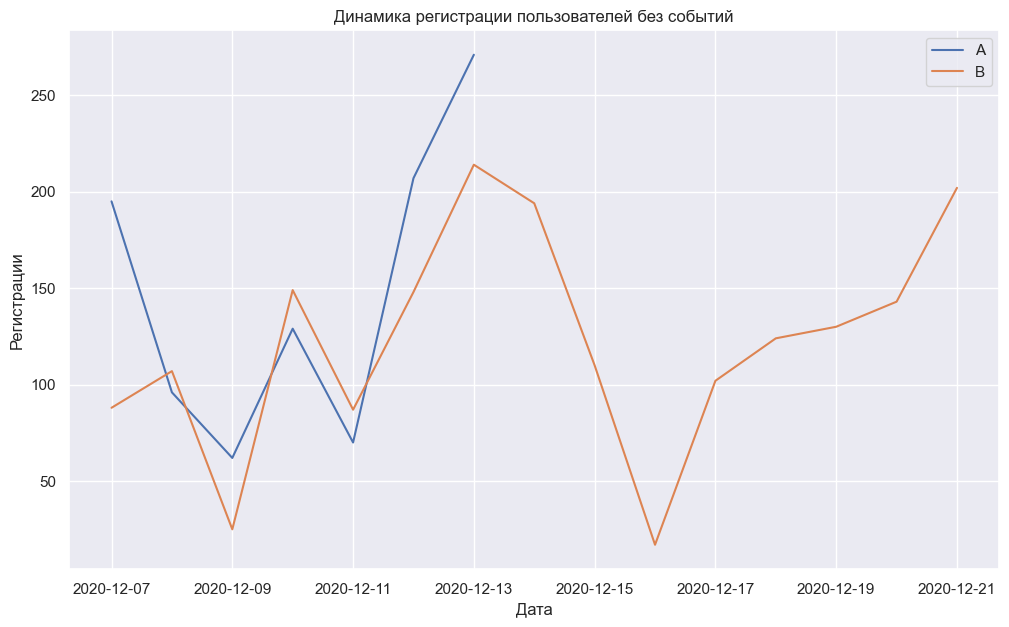

In [46]:
# зададим размер, тему и палитру графиков в проекте
plt.rcParams["figure.figsize"] = (12, 7)
sns.set_theme(style="darkgrid") 
sns.set_palette('deep')

plt.plot(data.loc[(data['event_dt'].isna()) & (data['group'] == 'A'), ['user_id', 'reg_dt']].groupby('reg_dt').count(), label='A')
plt.plot(data.loc[(data['event_dt'].isna()) & (data['group'] == 'B'), ['user_id', 'reg_dt']].groupby('reg_dt').count(), label='B')
plt.title('Динамика регистрации пользователей без событий')
plt.xlabel('Дата')
plt.ylabel('Регистрации')
plt.legend()
plt.show()

Количество регистраций пользователей без событий колеблется одинаково в обеих группах, однако 13 декабря в группе "А" такие регистрации полностью пропадают. Можно предположить, что данные по таким пользователям, зарегистрированным после 13 декабря, по группе "А" не выгружены.

Проверим остальные данные. Регистрацию можно представить как первый этап воронки - до логина. Рассмотрим, какова ситуация с другими этапами.

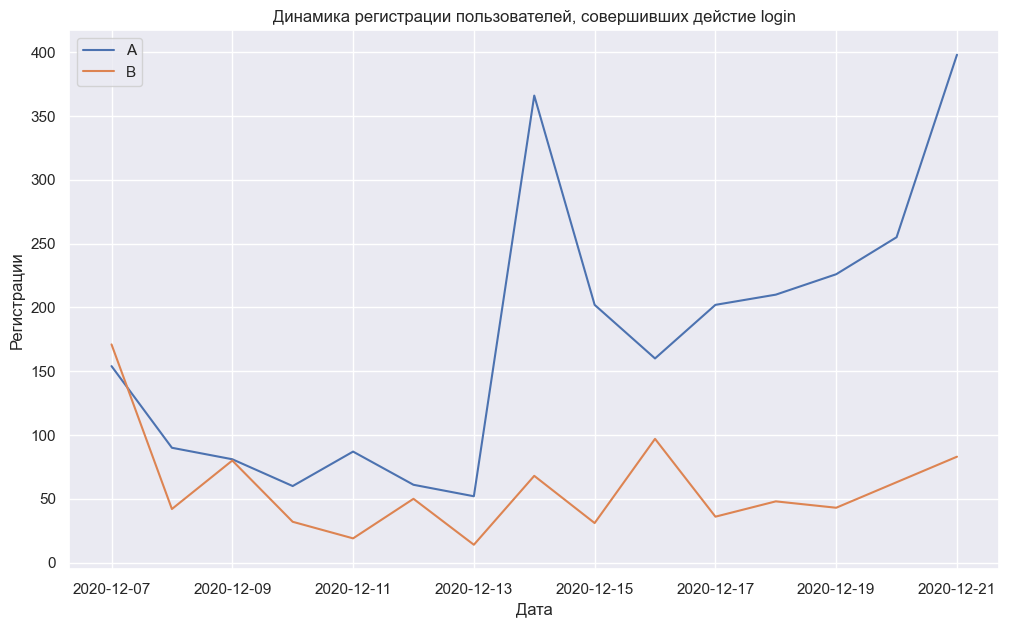

In [47]:
plt.plot(data.loc[(data['event_name'] == 'login') & (data['group'] == 'A'), ['user_id', 'reg_dt']].groupby('reg_dt').nunique(), label='A')
plt.plot(data.loc[(data['event_name'] == 'login') & (data['group'] == 'B'), ['user_id', 'reg_dt']].groupby('reg_dt').nunique(), label='B')
plt.title('Динамика регистрации пользователей, совершивших дейстие login')
plt.xlabel('Дата')
plt.ylabel('Регистрации')
plt.legend()
plt.show()

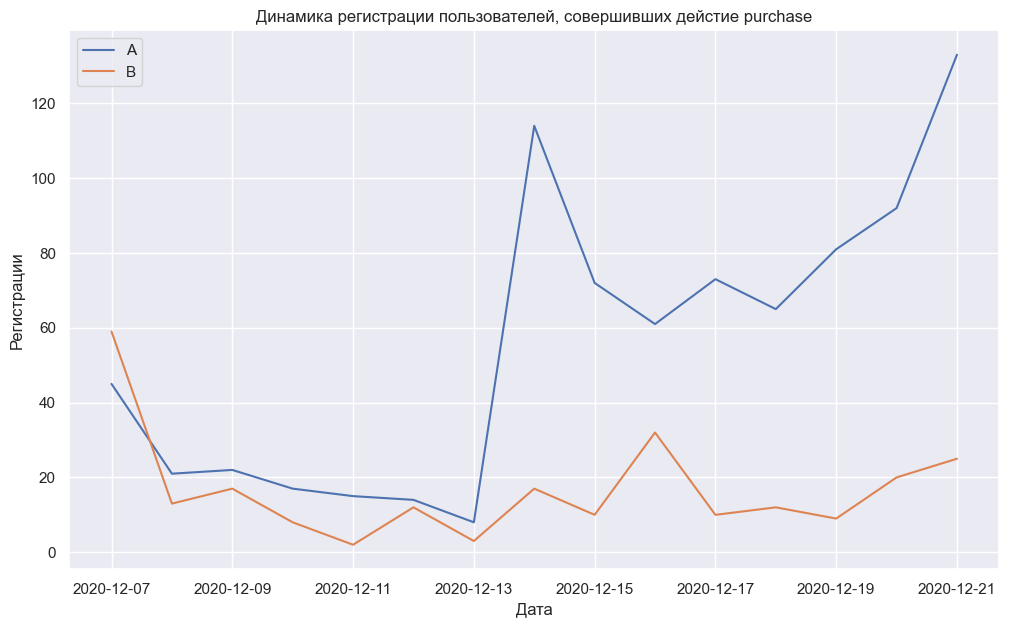

In [48]:
plt.plot(data.loc[(data['event_name'] == 'purchase') & (data['group'] == 'A'), ['user_id', 'reg_dt']].groupby('reg_dt').nunique(), label='A')
plt.plot(data.loc[(data['event_name'] == 'purchase') & (data['group'] == 'B'), ['user_id', 'reg_dt']].groupby('reg_dt').nunique(), label='B')
plt.title('Динамика регистрации пользователей, совершивших дейстие purchase')
plt.xlabel('Дата')
plt.ylabel('Регистрации')
plt.legend()
plt.show()

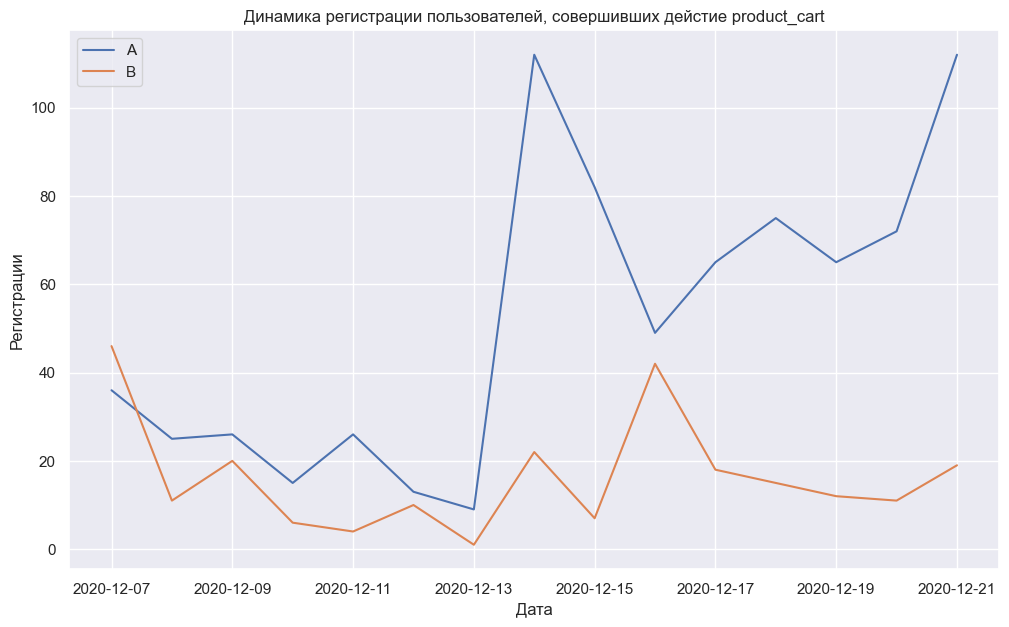

In [49]:
plt.plot(data.loc[(data['event_name'] == 'product_cart') & (data['group'] == 'A'), ['user_id', 'reg_dt']].groupby('reg_dt').nunique(), label='A')
plt.plot(data.loc[(data['event_name'] == 'product_cart') & (data['group'] == 'B'), ['user_id', 'reg_dt']].groupby('reg_dt').nunique(), label='B')
plt.title('Динамика регистрации пользователей, совершивших дейстие product_cart')
plt.xlabel('Дата')
plt.ylabel('Регистрации')
plt.legend()
plt.show()

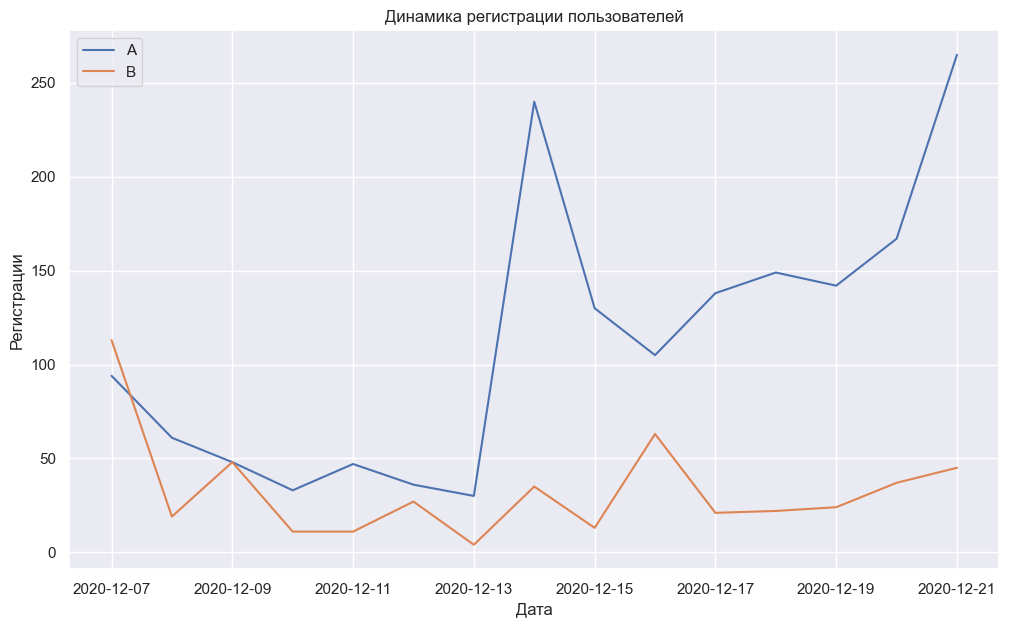

In [50]:
plt.plot(data.loc[(data['event_name'] == 'product_page') & (data['group'] == 'A'), ['user_id', 'reg_dt']].groupby('reg_dt').nunique(), label='A')
plt.plot(data.loc[(data['event_name'] == 'product_page') & (data['group'] == 'B'), ['user_id', 'reg_dt']].groupby('reg_dt').nunique(), label='B')
plt.title('Динамика регистрации пользователей')
plt.xlabel('Дата')
plt.ylabel('Регистрации')
plt.legend()
plt.show()

Мы видим, что с 13 декабря в группе "А" резко растет количество зарегистрированных пользователей, совершивших действие в любом из этапов воронки. Гипотезы причин произошедшего:
* Основная: до 13 декабря существовала техническая проблема, из-за которой пользователи не могли зайти в приложение после регистрации. 13 числа она была исправлена только для пользователей группы "А". Эта причина более вероятна, поскольку на всех этапах воронки динамика регистрации пользователей в группе "В" стабильна, а в группе "А" наблюдается сильный скачок. 
* Дополнительная: ошибка в выгрузке данных. До 13 декабря не выгружались события для части пользователей в обеих группах, после этой даты ошибку выгрузки исправили только для группы "А".

В любом случае тест был проведен некорректно, и результаты анализа будут искажены. Тем не менее, проведем исследование до конца.

Удалим пользователей без событий из датасета. Это существенно снизит мощность статистического теста.

In [51]:
print('Доля удаленных пользователей:', '{0:.2%}'.format(data.groupby('user_id')['event_name'].count().loc[lambda x : x == 0].count() / data['user_id'].nunique()))
data = data.dropna()

Доля удаленных пользователей: 45.19%


В ТЗ указано, что улучшение конверсии ожидается за 14 дней с момента регистрации пользователи.

Отфильтруем события, которые произошли после 14 лайфтайма.

In [52]:
data['lifetime'] = data['event_date'] - data['reg_dt']
data['lifetime'] = data['lifetime'].dt.days
print('Доля удаленных событий: {0:.2%}'.format(data.query('lifetime > 14')['event_name'].count() / data['event_name'].count()))
data = data.query('lifetime < 15')

Доля удаленных событий: 2.53%


**Вывод.** 
* Тест был закончен на 5 дней раньше, но к тому времени уже было набрано достаточно пользователей.
* Во время проведения теста состоялось новогоднее маркетинговое событие, но оно должно одинаково повлиять на обе группы.
* В данных по тесту содержались 5% пользователей из других регионов, они были уделены.
* 45% пользователей в тесте не имели событий. Они были неравномерно распределены по группам, что исказит результаты анализа.
* Пользователи без событий были удалены, что снизит мощность статистического критерия.

Последние 2 пункта дают право сказать, что тест проведен некорректно.

## Исследовательский анализ данных

### Распределение количества событий на пользователя

In [53]:
print('Событий на пользователя в группе А:', data.query('group == "A"')['event_name'].count() / data.query('group == "A"')['user_id'].nunique())
print('Событий на пользователя в группе B:', data.query('group == "B"')['event_name'].count() / data.query('group == "B"')['user_id'].nunique())

Событий на пользователя в группе А: 6.903609831029186
Событий на пользователя в группе B: 5.531356898517674


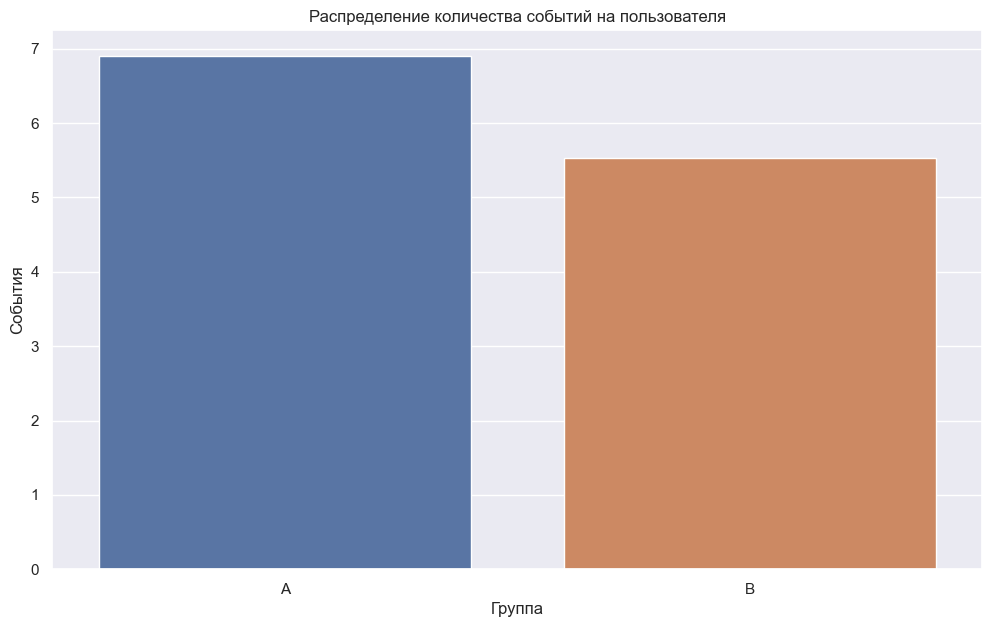

In [54]:
sns.barplot(y=[data.query('group == "A"')['event_name'].count() / data.query('group == "A"')['user_id'].nunique(),
              data.query('group == "B"')['event_name'].count() / data.query('group == "B"')['user_id'].nunique()],
            x=['A', 'B'])
plt.title('Распределение количества событий на пользователя')
plt.xlabel('Группа')
plt.ylabel('События')
plt.show()

Теперь посмотрим на метрику в динамике.

### Распределение количества событий по дням

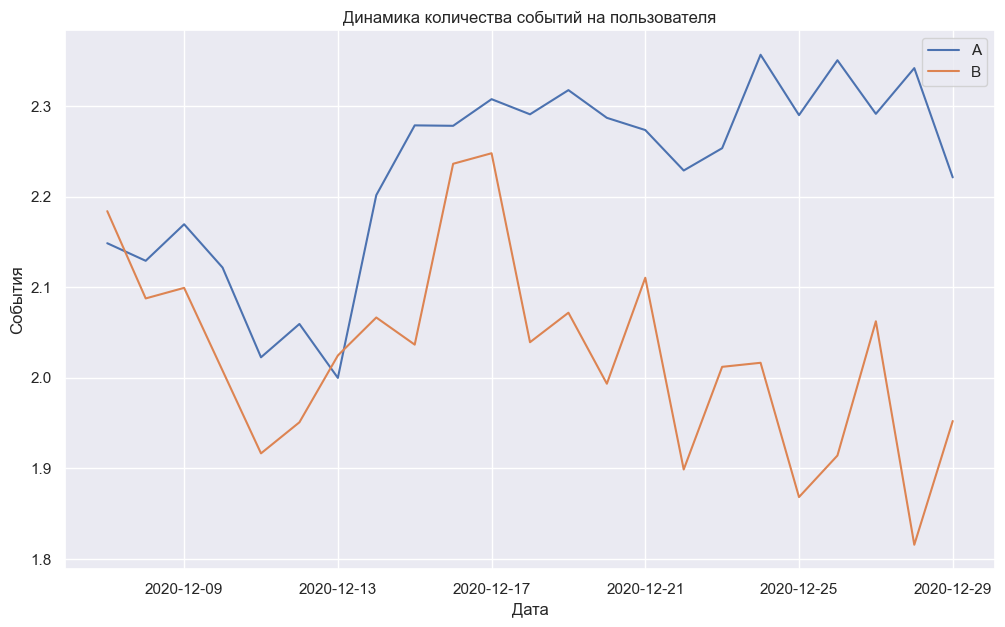

In [55]:
report = (data.query('group == "A"').groupby(['event_date'], as_index=False)
          .agg(n_users=('user_id', 'nunique'), events=('event_name', 'count'))
         )

report['events_per_user'] = (report['events'] / report['n_users'])
report = report.drop(columns=['n_users', 'events'])

sns.lineplot(x=report['event_date'], y=report['events_per_user'], legend='brief', label='A')

report = (data.query('group == "B"').groupby(['event_date'], as_index=False)
          .agg(n_users=('user_id', 'nunique'), events=('event_name', 'count'))
         )
report['events_per_user'] = (report['events'] / report['n_users']).drop(columns=['n_users', 'events'])
report = report.drop(columns=['n_users', 'events'])

sns.lineplot(x=report['event_date'], y=report['events_per_user'], legend='brief', label='B')
plt.title('Динамика количества событий на пользователя')
plt.xlabel('Дата')
plt.ylabel('События')
plt.show() 

В начале графика количество событий в группе "А" выше, но значения сопоставимы. После 13 декабря наблюдается стремительный рост в группе "А" с 2 до 2,3 событий в день на пользователя, что может быть вызвано некорректным проведением теста, описанным выше. 

График группы "B" гораздо менее стабильный.

### Изменения конверсии на разных этапах

Для начала определим последовательность этапов воронки.

In [56]:
data.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

event_name
login           3480
product_page    2178
purchase        1082
product_cart    1026
Name: user_id, dtype: int64

Все пользователи хоть раз входили в систему. 

Событий "переход в корзину" меньше, чем покупок. Это значит, что пользователи могут пропустить один из шагов, например, можно совершить быструю покупку на странице товара.

Начнем с конверсии в просмотр карточек товаров.

In [57]:
print('Конверсия в product_page группы А:', '{0:.2%}'.format(data.query('event_name == "product_page" and group == "A"')['user_id'].nunique() / data.query('group == "A"')['user_id'].nunique()))
print('Конверсия в product_page группы B:', '{0:.2%}'.format(data.query('event_name == "product_page" and group == "B"')['user_id'].nunique() / data.query('group == "B"')['user_id'].nunique()))

Конверсия в product_page группы А: 64.71%
Конверсия в product_page группы B: 56.21%


Контрольная группа показывает гораздо более хорошие результаты, чем группа с изменениями.

In [58]:
print('Конверсия в product_cart группы А:', '{0:.2%}'.format(data.query('event_name == "product_cart" and group == "A"')['user_id'].nunique() / data.query('group == "A"')['user_id'].nunique()))
print('Конверсия в product_cart группы B:', '{0:.2%}'.format(data.query('event_name == "product_cart" and group == "B"')['user_id'].nunique() / data.query('group == "B"')['user_id'].nunique()))

Конверсия в product_cart группы А: 30.03%
Конверсия в product_cart группы B: 27.82%


На этом этапе разница сильно снижается, но сохраняется лидерство группы "А".

In [59]:
print('Конверсия в purchase группы А:', '{0:.2%}'.format(data.query('event_name == "purchase" and group == "A"')['user_id'].nunique() / data.query('group == "A"')['user_id'].nunique()))
print('Конверсия в purchase группы B:', '{0:.2%}'.format(data.query('event_name == "purchase" and group == "B"')['user_id'].nunique() / data.query('group == "B"')['user_id'].nunique()))

Конверсия в purchase группы А: 31.99%
Конверсия в purchase группы B: 28.39%


Конверсия в покупки на 3.6% хуже в группе с новой системой рекомендаций.


**Вывод.**
* В группе "A" событий в среднем на пользователя больше.
* В начале рассматриваемого периода в группах сопоставимое количество событий, но с 13 декабря наблюдается резкий рост в группе "А".
* Конверсия в контрольной группе выше на всех этапах.
* Разница между группами в конверсии в переход в корзину и покупку гораздо ниже, чем разница в конверсии в просмотр карточки товара.

## Анализ результатов A/B-тестирования

Проверим, имеет ли разница в конверсии, полученная в результате исследования, статистическую значимость. Тестировать будем 3 этапа, поэтому применим поправку Бонферрони и возьмем alpha 0.01667.

In [60]:
count_a = data.query('event_name == "product_page" and group == "A"')['user_id'].nunique()

nobs_a = data.query('group == "A"')['user_id'].nunique()

count_b = data.query('event_name == "product_page" and group == "B"')['user_id'].nunique()

nobs_b = data.query('group == "B"')['user_id'].nunique()

stat, pval = proportions_ztest([count_a, count_b], [nobs_a, nobs_b])

print(count_a, count_b,nobs_a, nobs_b)
alpha = 0.01667

print(pval) 
if pval < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1685 493 2604 877
6.94273935952599e-06
Отвергаем нулевую гипотезу


Конверсия в просмотр карточек товаров действительно выше в контрольной группе на этапе просмотра карточки товара.

In [61]:
count_a = data.query('event_name == "product_cart" and group == "A"')['user_id'].nunique()

nobs_a = data.query('group == "A"')['user_id'].nunique()

count_b = data.query('event_name == "product_cart" and group == "B"')['user_id'].nunique()

nobs_b = data.query('group == "B"')['user_id'].nunique()

stat, pval = proportions_ztest([count_a, count_b], [nobs_a, nobs_b])

print(count_a, count_b,nobs_a, nobs_b)

print(pval) 
if pval < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

782 244 2604 877
0.21469192029582396
Не получилось отвергнуть нулевую гипотезу


На этапе перехода в корзину у разницы в конверсии нет статистической значимости.

In [62]:
count_a = data.query('event_name == "purchase" and group == "A"')['user_id'].nunique()

nobs_a = data.query('group == "A"')['user_id'].nunique()

count_b = data.query('event_name == "purchase" and group == "B"')['user_id'].nunique()

nobs_b = data.query('group == "B"')['user_id'].nunique()

stat, pval = proportions_ztest([count_a, count_b], [nobs_a, nobs_b])

print(count_a, count_b,nobs_a, nobs_b)

print(pval) 
if pval < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

833 249 2604 877
0.04652482738393029
Не получилось отвергнуть нулевую гипотезу


Конверсия в покупку также не отличается между группами с достаточной статистической значимостью.

**Вывод.**
* Есть статистически значимая разница между группами в конверсии в просмотр карточки продукта, переход в корзину и покупку.

## Вывод

* В рамках проекта анализировались данные A/B-теста 15% европейских пользователей за период с 7 по 30 декабря 2020 года.
* В датасете содержатся данные пользователей контрольной группы "А" и группы "B", пользователям которой была внедрена улучшенная рекомендательная система.
* Строгой воронки конверсии нет, поскольку пользователи могут пропустить некоторые из шагов.
* В ходе исследования было обнаружено, что тест проведен некорректно. 45% пользователей в тесте не имели событий. Они были неравномерно распределены по группам, что искажает результаты анализа.
* По имеющимся данным можно сделать вывод, что конверсия у пользователей с новой системой ниже, чем у пользователей контрольной группы, хотя ожидалось повышение на 10%.
* Рекомендуется не руководствоваться результатами этого теста и провести новый корректный.